# 1. Import and Install Dependencies

## 1.1 Install Dependencies

<b>Windows 10/11</b> setup:
<br>

1) Download and install Python 3.10.11:
<br>
https://www.python.org/downloads/release/python-31011/
<br>
`"add python.exe to PATH"` during installation.
<br>
Restart Windows

2) Create Virtual environment:
<br>
Open terminal in the project folder.
<br>
`python -m venv venv`

3) Activate venv:
<br>
`venv\Scripts\activate`

4) Update pip:
<br>
`python -m pip install --upgrade pip`

5) Install dependencies:
<br>
`pip install tensorflow-gpu<2.11 matplotlib==3.7.* librosa scikit-learn pandas numpy ipykernel seaborn pyartnet sounddevice joblib`

6) Restart kernel (this notebook)


## 1.2 Training settings

Setup parameters for the machine learning system.
<br>See [model.md](./model.md) for more information about neural network architectures

In [1]:
# Audio parameters
AUDIO_CHUNK = 0.4 # seconds
SLICE_AUDIO = False
DATA_RANGE = 255   # 1 or 255
NUM_CHANNELS = 1
SAMPLE_RATE = 48000

# Features:
#MAIN_FEATURE = 'mel'    # mel, spec, mfcc
#SECONDARY_FEATURE =  "chroma" # chroma, contrast, tonnetz

# Mel spectrogram parameters:
#N_FRAMES = None
N_MELS = 256
NFFT = 2048
FMAX = SAMPLE_RATE // 2
HOP_LENGTH = 512
# Spectrogram Parameters:


# Training settings
EPOCHS = 12
BATCH_SIZE = 8

# Model settings
MODEL_ARCH = "effnetv2_nn"
MODEL_TYPE = "base"
NEW_MODEL_NAME = 'test01'

## 1.3 Load Dependencies

In [52]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
from classify_utilities import AudioProcessor
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
import librosa
import numpy as np
import joblib
import random
from model import Deep_NN
from IPython.display import Audio, display

In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 2. Preprocess the Data

- Put recorded dataset into "DATASET" folder.
- Recorded dataset shall be in format, where each audio class has its separate folder.
- Folders are named as wanted classification labels.

You can use "Dataset Recorder" tool to produce such dataset. 
<br>(https://github.com/Teapack1/Audio-Dataset-Recorder-Tools)

<br>example command to produce dataset:
<br>`python dr.py --classes wine_cling whiskey_cling --duration 0.5 --num_samples 100 --playback --treshold 0.25 --sample_rate 48000`

## 2.1 Define Paths to Files

In [59]:
DATASET_DIR = 'DATASET'
DATA_DIR = 'data'
TEST_DIR = 'TEST_DATA'
PLOTS_DIR = 'PLOTS'
METADATA = "metadata.csv"
MODEL_PATH = os.path.join("MODEL", f"model-{NEW_MODEL_NAME}-{MODEL_ARCH}-{MODEL_TYPE}")
LITE_MODEL_PATH = os.path.join("MODEL", f"model-{NEW_MODEL_NAME}-{MODEL_ARCH}-{MODEL_TYPE}.tflite")
LABELER_PATH = os.path.join("MODEL", f"labeler-{NEW_MODEL_NAME}-{MODEL_ARCH}-{MODEL_TYPE}.joblib")

# create folders if they don't exist
if not os.path.exists('MODEL'):
    os.makedirs('MODEL')
if not os.path.exists('data'):
    os.makedirs('data')
if not os.path.exists('TEST_DATA'):
    os.makedirs('TEST_DATA')
if not os.path.exists('DATASET'):
    os.makedirs('DATASET')
if not os.path.exists('PLOTS'):
    os.makedirs('PLOTS')

In [5]:
dataset_files = os.listdir('dataset')
model_files = os.listdir('model')
test_files = os.listdir('TEST_DATA')

print("Files in 'DATASET' folder:")
print(dataset_files)

print("Files in 'MODEL' folder:")
print(model_files)

print("Files in 'TEST' folder:")
print(test_files)

Files in 'DATASET' folder:
['attention', 'cheers', 'clap', 'finger_snap', 'metal_metal', 'metal_metal_knock', 'metal_wood', 'metal_wood_knock', 'not']
Files in 'MODEL' folder:
['label_encoder.joblib', 'model', 'model-defaultCNN-base', 'model-defaultCNN-base.keras', 'model.tflite', 'model.tflite-defaultCNN-base', 'model_MobileNetSmall.keras', 'model_VGGSmall.keras']
Files in 'TEST' folder:
['MobileNetSmall.png', 'MobileNetSmall_plot1.png', 'MobileNetSmall_plot2.png', 'VGGSmall.png']


In [6]:
audio_processor = AudioProcessor(sample_rate=SAMPLE_RATE, 
                                 n_mels = N_MELS,
                                 fmax = FMAX,
                                 n_fft = NFFT,
                                 hop_length = HOP_LENGTH, 
                                 audio_chunk = AUDIO_CHUNK,
                                 slice_audio = SLICE_AUDIO,
                                 data_range=DATA_RANGE
                                 )
                

## 2.2 Label Encoding

In [7]:
def encoder_fn(dataset_dir, labeler_dir, encoder, dump=False): 

    classes = os.listdir(dataset_dir)
    classes.sort()
    classes = np.array(classes).reshape(-1, 1)

    try:
        encoder.fit(classes)
    except IndexError:
        print("No classes found in dataset folder")
    if dump:
        joblib.dump(encoder, labeler_dir)

def idx2label(idx, encoder):
    idx_reshaped = np.array(idx).reshape(1, -1)
    return encoder.inverse_transform(idx_reshaped)[0][0]

def label2idx(label, encoder):
    label = np.array(label).reshape(-1, 1)
    return encoder.transform(label).toarray()[0]

In [8]:
oh_encoder = OneHotEncoder()

encoder_fn(dataset_dir=DATASET_DIR, labeler_dir=LABELER_PATH, encoder=oh_encoder)

In [9]:
random_label = random.choice(os.listdir(DATASET_DIR))
label2idx(random_label, oh_encoder)

array([0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [10]:
idx2label(label2idx(random_label, oh_encoder), oh_encoder)

'metal_metal'

## 2.3 Exploratory data analysis

### Produce metadata dataframe

In [11]:
# Analyze dataset:
# List all the files in dictionare and subdictionaries.
metadata = []

for root, _, files in os.walk(DATASET_DIR):
    for i, file in enumerate(files):
        if file.endswith('.wav'):
            filename = os.path.join(root, file)
            label = os.path.basename(root)
            class_ = label2idx(label, oh_encoder)
            num_channels, sample_rate, bit_depth, avg_rms, length_in_seconds, length_in_frames = audio_processor.read_file_properties(filename)
            metadata.append({
                'filename': filename, 
                'label': label, 
                'class': class_,
                'num_channels': num_channels, 
                'sample_rate': sample_rate, 
                'bit_depth': bit_depth, 
                'avg_rms': avg_rms, 
                'length_in_seconds': length_in_seconds, 
                'length_in_frames': length_in_frames
            })

            print(f"Processing label: {label}, {i}th file named: {file}")
        else:
            print(f"Skipped {i} file. {file}")
            
metadata = pd.DataFrame(metadata)
metadata.to_csv(METADATA, index=False)

Skipped 0 file. attention_bim256_0001.png
Skipped 1 file. attention_bim256_0002.png
Skipped 2 file. attention_bim256_0003.png
Skipped 3 file. attention_bim256_0004.png
Skipped 4 file. attention_bim256_0005.png
Skipped 5 file. attention_bim256_0006.png
Skipped 6 file. attention_bim256_0007.png
Skipped 7 file. attention_bim256_0008.png
Skipped 8 file. attention_bim256_0009.png
Skipped 9 file. attention_bim256_0010.png
Skipped 10 file. attention_bim256_0011.png
Skipped 11 file. attention_bim256_0012.png
Skipped 12 file. attention_bim256_0013.png
Skipped 13 file. attention_bim256_0014.png
Skipped 14 file. attention_bim256_0015.png
Skipped 15 file. attention_bim256_0016.png
Skipped 16 file. attention_bim256_0017.png
Skipped 17 file. attention_bim256_0018.png
Skipped 18 file. attention_bim256_0019.png
Skipped 19 file. attention_bim256_0020.png
Skipped 20 file. attention_bim256_0021.png
Skipped 21 file. attention_bim256_0022.png
Skipped 22 file. attention_bim256_0023.png
Skipped 23 file. atte

### Observe the data

In [12]:
metadata.head()

,filename,label,class,num_channels,sample_rate,bit_depth,avg_rms,length_in_seconds,length_in_frames
0,DATASET\attention\attention_juray856_0261.wav,attention,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1,44100,16,0.013348,0.397982,17551
1,DATASET\attention\attention_juray856_0262.wav,attention,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1,44100,16,0.017089,0.397982,17551
2,DATASET\attention\attention_juray856_0263.wav,attention,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1,44100,16,0.028943,0.397982,17551
3,DATASET\attention\attention_juray856_0264.wav,attention,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1,44100,16,0.025356,0.397982,17551
4,DATASET\attention\attention_juray856_0265.wav,attention,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1,44100,16,0.016789,0.397982,17551


### class balance

In [13]:
print(metadata["label"].value_counts())

label
cheers               1135
attention             873
metal_wood            576
finger_snap           540
clap                  500
metal_metal           500
metal_metal_knock     500
metal_wood_knock      500
not                   352
Name: count, dtype: int64


### plot class waveforms

DATASET\attention\attention_juray856_0261.wav
DATASET\cheers\cheers_bim256_0001.wav
DATASET\clap\combCafeKlatsch22_0001.wav
DATASET\finger_snap\combCafeSchnalzen64_0001.wav
DATASET\metal_metal\combCafeMetalMetal56_0001.wav
DATASET\metal_metal_knock\combCafeMetalMetalKlopfen62_0001.wav
DATASET\metal_wood\combCafeMetalHolz48_0001.wav
DATASET\metal_wood_knock\combCafeMetalHolzKlopfen54_0001.wav
DATASET\not\data_0430.wav


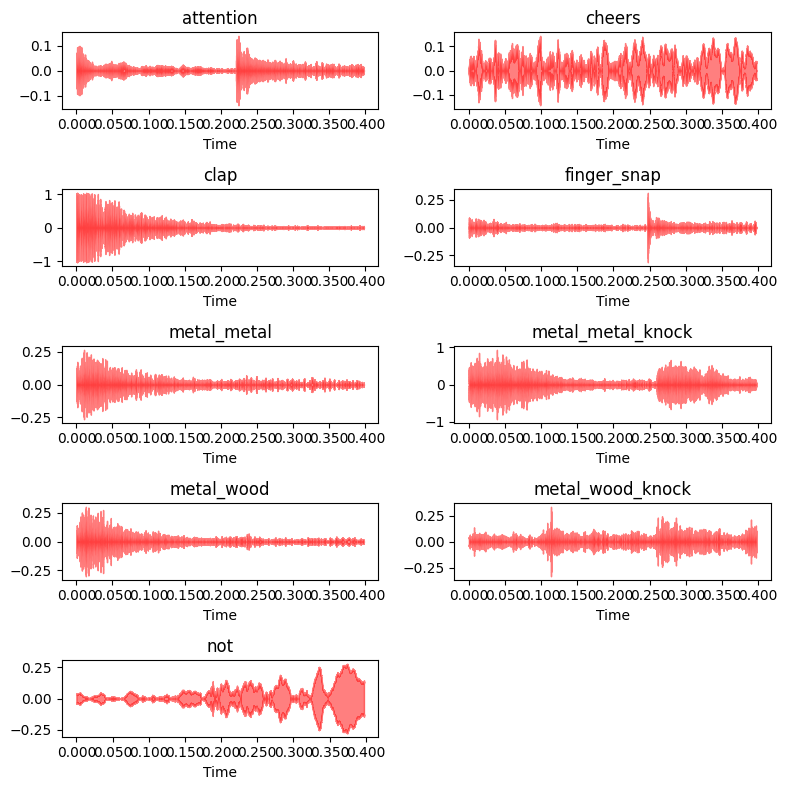

In [14]:
labels = metadata["label"].unique()

fig = plt.figure(figsize=(8,8))

fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, label in enumerate(labels):
    filtered_df = metadata[metadata["label"] == label]
    slice_file_name = filtered_df["filename"].iloc[0]
    fold = filtered_df["label"].iloc[0]
    fig.add_subplot(5, 2, i+1)
    plt.title(label)
    data, sr = librosa.load(os.path.join(slice_file_name), sr=SAMPLE_RATE, mono=False)
    librosa.display.waveshow(y = data, sr=sr, color="r", alpha=0.5, label='Harmonic')
    print(slice_file_name)
     
plt.tight_layout()  # This will adjust spacing between subplots to prevent overlap
plt.show()  # This will display the plot

In [15]:
# num of channels 
print("Channels: ")
print(metadata.num_channels.value_counts(normalize=True))
print("\n")

# sample rates 
print("Sample Rates: ")
print(metadata.sample_rate.value_counts(normalize=True))
print("\n")

# bit depth
print("Bit Depth: ")
print(metadata.bit_depth.value_counts(normalize=True))
print("\n")

# length in samples
print("Samples: ")
print(metadata.length_in_frames.describe())
print("\n")

# length in seconds
print("Length (s): ")
print(metadata.length_in_seconds.describe())

# RMS
print(metadata.avg_rms.describe())


Channels: 
num_channels
1    1.0
Name: proportion, dtype: float64


Sample Rates: 
sample_rate
44100    1.0
Name: proportion, dtype: float64


Bit Depth: 
bit_depth
16    1.0
Name: proportion, dtype: float64


Samples: 
count     5476.000000
mean     17550.035793
std          3.679115
min      17536.000000
25%      17551.000000
50%      17551.000000
75%      17551.000000
max      17551.000000
Name: length_in_frames, dtype: float64


Length (s): 
count    5476.000000
mean        0.397960
std         0.000083
min         0.397642
25%         0.397982
50%         0.397982
75%         0.397982
max         0.397982
Name: length_in_seconds, dtype: float64
count    5476.000000
mean        0.037807
std         0.025355
min         0.005258
25%         0.021814
50%         0.031939
75%         0.045871
max         0.358024
Name: avg_rms, dtype: float64


## 2.4 Audio Preprocessing:

### Test audio preprocessing methods
-   Librosa -> 
        SR: 22050
        channel: 1
    trim/pad ->
        length: 3s (3x22050)
    spectrogram ->
        mel-spectrogram / spectrogram / MFCC
    post-process ->
        to Db (log scale, more apparent patterns)
        abs 
    normalize ->
        
        


audio_file shape (19104,) - (frames, channels)
audio_file sample rate 48000 Hz
Spectrogram shape (256, 38) - (mels/frequency, frames/time)
spectrogram min: 0.0 spectrogram max: 1.0, average: 0.5365239977836609
spectrogram dtype: float32
audio dtype: float32 - bit depth


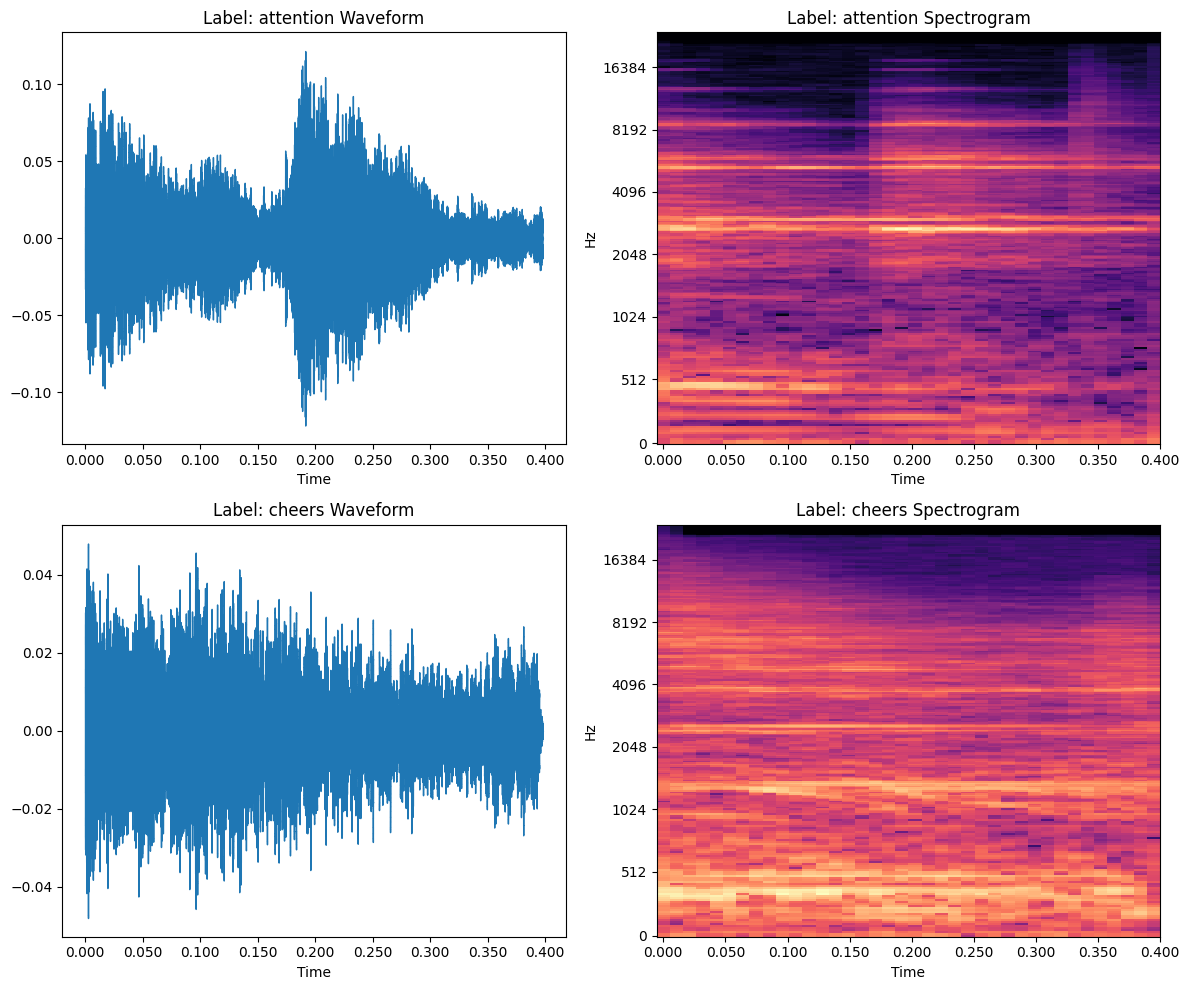

In [16]:
# Test the Fourier transform
#In each iteration of the loop, the variable index is assigned the index value of the current row, and the variable row is assigned the data of the current row (as a Series object).
rows = metadata.iloc[[34, 1280]]

#rows = metadata.sample(2)
slice_length = AUDIO_CHUNK
samples_show = len(rows)
pass_ = 0

fig, axes = plt.subplots(nrows=samples_show, ncols=2, figsize=(12, samples_show* 5))

for i, row in rows.iterrows():    
    if pass_ > samples_show:
        break
    audio_file, librosa_sample_rate = librosa.load(row["filename"], sr=SAMPLE_RATE)
    if SLICE_AUDIO: 
        print(slice)
        sample_length = slice_length * librosa_sample_rate

        audio_file = audio_file[:sample_length]
        if len(audio_file) < sample_length:
            audio_file = np.pad(audio_file, (0, sample_length - len(audio_file)), constant_values=0)

    #spectrogram = audio_processor(data = audio_file)
    spectrogram = librosa.feature.melspectrogram(y=audio_file, sr=librosa_sample_rate, n_mels=256, fmax = FMAX, n_fft=2048, hop_length=512)
    spectrogram = (librosa.power_to_db(spectrogram, ref=np.max))

    # general scale normalization with min-max
    #min_db, max_db = -60, 80
    #spectrogram = np.clip((spectrogram - min_db) / (max_db - min_db), 0, 1)
    #spectrogram = (spectrogram - min_db) / (max_db - min_db)

    # Min-Max normalization
    spectrogram = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min())

        # wave Plot
    axes[pass_, 0].set_title(f"Label: {row['label']} Waveform")
    librosa.display.waveshow(audio_file, sr=librosa_sample_rate, ax=axes[pass_, 0])
    # spectrogram plot
    axes[pass_, 1].set_title(f"Label: {row['label']} Spectrogram")
    img = librosa.display.specshow(spectrogram, sr=librosa_sample_rate, x_axis='time', y_axis='mel', ax=axes[pass_, 1])
    pass_ += 1


print(f"audio_file shape {audio_file.shape} - (frames, channels)")
print(f"audio_file sample rate {librosa_sample_rate} Hz")
print(f"Spectrogram shape {spectrogram.shape} - (mels/frequency, frames/time)")
print(f"spectrogram min: {spectrogram.min()} spectrogram max: {spectrogram.max()}, average: {spectrogram.mean()}")
print(f"spectrogram dtype: {spectrogram.dtype}")
print(f"audio dtype: {audio_file.dtype} - bit depth")

#fig.colorbar(img, ax=axes[:, 0], format='%+2.0f dB')
plt.tight_layout()
plt.show()

## 3 Prepare Dataset

## 3.1 Extract features and labels into dataframe

In [17]:
# Preprocessing function

def extract_features(row):
    
    class_label = row["class"]
    
    audio_file,_ = librosa.load(row["filename"], sr=SAMPLE_RATE)

    spectrogram = audio_processor(
        data = audio_file, data_range = DATA_RANGE) # 1 or 255 range
    
    shape = spectrogram.shape

    return spectrogram, class_label, shape

In [18]:
#In each iteration of the loop, the variable index is assigned the index value of the current row, and the variable row is assigned the data of the current row (as a Series object).
features = []

for index, row in metadata.iterrows():
    features.append(extract_features(row))
    print(f"Processed {index} file. {row['filename']}")

   
dataset_df = pd.DataFrame(features, columns=["features", "class_label", "shape"])
print('Finished feature extraction from ', len(dataset_df), ' files') 
N_FRAMES = dataset_df["shape"].iloc[0][0]
print(f"Number of frames: {N_FRAMES}")

Processed 0 file. DATASET\attention\attention_juray856_0261.wav
Processed 1 file. DATASET\attention\attention_juray856_0262.wav
Processed 2 file. DATASET\attention\attention_juray856_0263.wav
Processed 3 file. DATASET\attention\attention_juray856_0264.wav
Processed 4 file. DATASET\attention\attention_juray856_0265.wav
Processed 5 file. DATASET\attention\attention_juray856_0266.wav
Processed 6 file. DATASET\attention\attention_juray856_0267.wav
Processed 7 file. DATASET\attention\attention_juray856_0268.wav
Processed 8 file. DATASET\attention\attention_juray856_0269.wav
Processed 9 file. DATASET\attention\attention_juray856_0270.wav
Processed 10 file. DATASET\attention\attention_juray856_0271.wav
Processed 11 file. DATASET\attention\attention_juray856_0272.wav
Processed 12 file. DATASET\attention\attention_juray856_0273.wav
Processed 13 file. DATASET\attention\attention_juray856_0274.wav
Processed 14 file. DATASET\attention\attention_juray856_0275.wav
Processed 15 file. DATASET\attentio

### Our feature data stats:

In [19]:
dataset_df.head()

,features,class_label,shape
0,"[[225.84837, 224.72015, 208.26218, 180.41876, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","(38, 256)"
1,"[[217.37027, 216.59056, 213.22665, 180.12415, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","(38, 256)"
2,"[[164.86537, 164.79172, 172.2986, 153.32108, 1...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","(38, 256)"
3,"[[176.58948, 176.77618, 186.73418, 188.43875, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","(38, 256)"
4,"[[207.28879, 206.49936, 202.90047, 195.09433, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","(38, 256)"


In [20]:
print(f"Dataset shape: {dataset_df['shape'].value_counts()}")
print(f"Data values Min: {dataset_df['features'].apply(lambda x: x.min()).min()}, Max: {dataset_df['features'].apply(lambda x: x.max()).max()}, dtype: {dataset_df['features'].apply(lambda x: x.dtype).unique()} \nAverage: {dataset_df['features'].apply(lambda x: x.mean()).mean()}, Median: {dataset_df['features'].apply(lambda x: x.mean()).median()}")
print(f"Number of time frames N_FRAMES: {N_FRAMES}")

Dataset shape: shape
(38, 256)    5476
Name: count, dtype: int64
Data values Min: 0.0, Max: 255.0, dtype: [dtype('float32')] 
Average: 121.07283782958984, Median: 124.36866760253906
Number of time frames N_FRAMES: 38


## 3.2 Train Test Split

In [21]:
X = np.array(dataset_df.features.tolist())
y = np.array(dataset_df.class_label.tolist())
X.shape

(5476, 38, 256)

In [22]:
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state = 42)

### Double check prepared dataset

In [23]:
print(f"randomm feature example: {X[0]} and label: {y[0]}")

randomm feature example: [[225.84837  224.72015  208.26218  ...  82.617256  81.98616   81.60039 ]
 [241.6064   240.38791  216.51985  ...  63.236595  62.615337  62.234825]
 [239.81366  238.78554  227.53354  ...   0.         0.         0.      ]
 ...
 [201.65157  201.7939   211.36699  ...   0.         0.         0.      ]
 [206.7878   206.69356  213.9847   ...   0.         0.         0.      ]
 [193.68573  192.94194  190.4133   ...   0.         0.         0.      ]] and label: [1. 0. 0. 0. 0. 0. 0. 0. 0.]


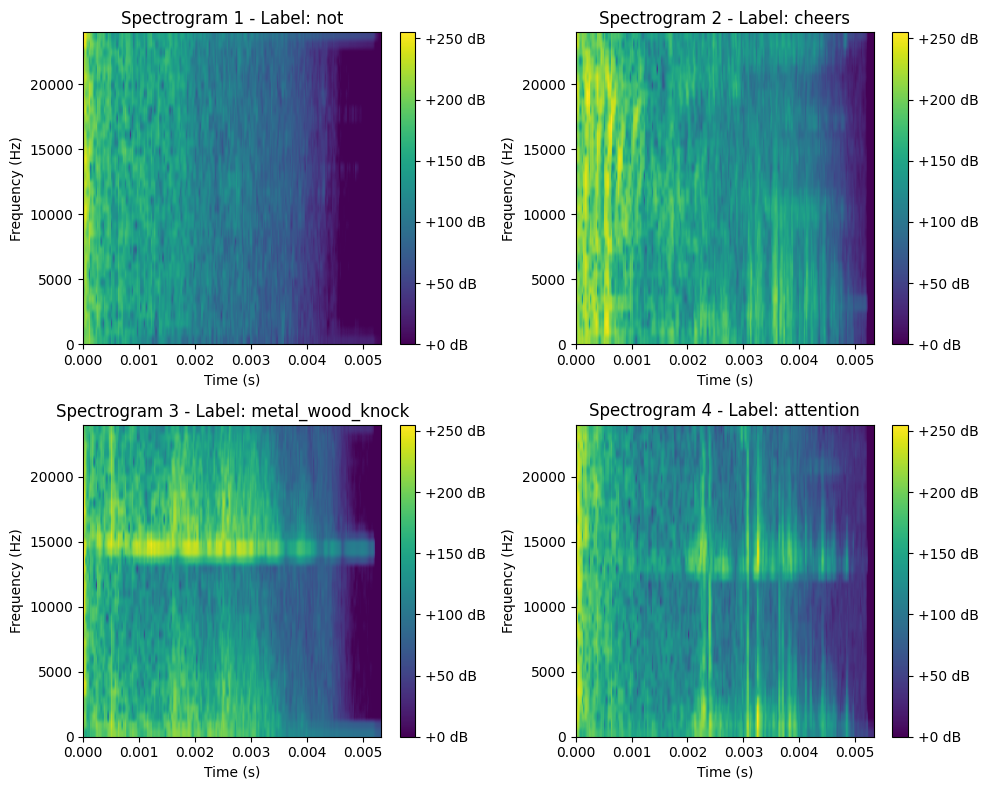

In [24]:
selected_rows = dataset_df.sample(n=4)

# Create subplots with 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Iterate over the subplots and fill each with a spectrogram
for i, (idx, row) in enumerate(selected_rows.iterrows()):
    spectrogram = row['features']
    label = row['class_label']
    ax = axs[i // 2, i % 2]  # Calculate the subplot position
    im = ax.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis',
                   extent=[0, spectrogram.shape[1] / SAMPLE_RATE, 0, SAMPLE_RATE / 2])
    ax.set_title(f'Spectrogram {i+1} - Label: {idx2label(label, oh_encoder)}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    fig.colorbar(im, ax=ax, format='%+2.0f dB')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

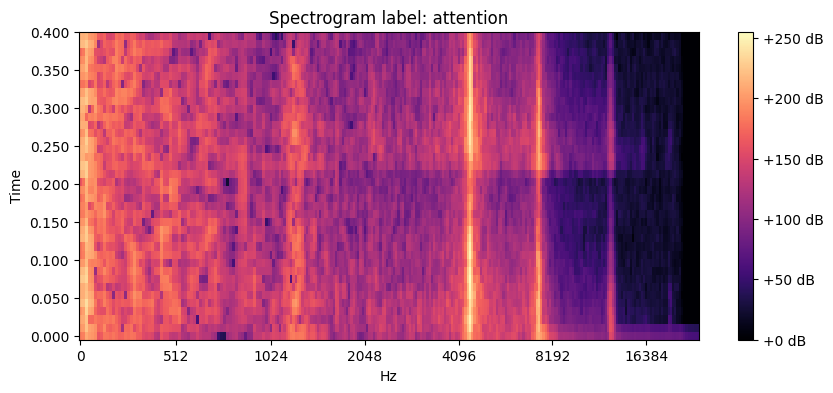

In [25]:
# Get the random feature array
sample_no = 42
sample_f = dataset_df.iloc[sample_no]["features"]
sample_l = dataset_df.iloc[sample_no]["class_label"]
# Plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(sample_f, sr=SAMPLE_RATE, x_axis='mel', y_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram label: ' + idx2label(sample_l, oh_encoder))
plt.show()

## 3.3 Reshape sets for NN input layer

In [26]:
x_train = x_train.reshape(x_train.shape[0], N_FRAMES, N_MELS, NUM_CHANNELS)
x_test = x_test.reshape(x_test.shape[0], N_FRAMES, N_MELS, NUM_CHANNELS)

num_labels = y.shape[1]
print(f"num_labels: {num_labels}")
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

num_labels: 9
x_train shape: (4380, 38, 256, 1)
y_train shape: (4380, 9)


# 4. Build Deep Learning Model

## 4.1 Load deep neural net

In [27]:
# load a class with various model archietectures to test
modelClass = Deep_NN(num_classes=num_labels, dim1 = N_FRAMES, dim2 = N_MELS, dim3 = NUM_CHANNELS)

In [28]:
# Choose model architecture to train on
# MODEL_ARCH = customCNN1 mobilenetv3_nn convnext_nn effnetv2_nn dense_nn
# MODEL_TYPE = small large tiny base (optional)
#MODEL_ARCH = "dense_nn"
#MODEL_TYPE = "small"

model = getattr(modelClass, MODEL_ARCH)(type=MODEL_TYPE)

#model = modelClass.defaultCNN()

Active Neural Net: 'effnetv2_nn' base, 
 Input Shape: (38, 256, 1) 
 Num Classes: 9 

Expected data range: 0 - 255


## 4.2 Compile Sequential Model

In [29]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [30]:
from tensorflow.keras.metrics import Precision, Recall

model.compile(
    optimizer=optimizer, 
    loss='CategoricalCrossentropy', 
    metrics=['accuracy', Precision(), Recall()]
    )

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 38, 256, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 rescaling (Rescaling)          (None, 38, 256, 1)   0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 19, 128, 24)  216         ['rescaling[0][0]']              
                                                                                                  
 stem_bn (BatchNormalization)   (None, 19, 128, 24)  96          ['stem_conv[0][0]']          

## 4.3 Fit Model, View Loss and KPI Plots

In [32]:
hist = model.fit(x_train, 
                 y_train, 
                 epochs=EPOCHS, 
                 validation_data=(x_test, y_test), 
                 batch_size=BATCH_SIZE
                 )

Epoch 1/12
548/548 [==============================] - 125s 186ms/step - loss: 1.9062 - accuracy: 0.4279 - precision: 0.5348 - recall: 0.3016 - val_loss: 1.3077 - val_accuracy: 0.6414 - val_precision: 0.7255 - val_recall: 0.5547
Epoch 2/12
548/548 [==============================] - 102s 185ms/step - loss: 0.9438 - accuracy: 0.6982 - precision: 0.7619 - recall: 0.6121 - val_loss: 0.5234 - val_accuracy: 0.8358 - val_precision: 0.8667 - val_recall: 0.8066
Epoch 3/12
548/548 [==============================] - 103s 187ms/step - loss: 0.6513 - accuracy: 0.7943 - precision: 0.8343 - recall: 0.7493 - val_loss: 0.3855 - val_accuracy: 0.8978 - val_precision: 0.9152 - val_recall: 0.8759
Epoch 4/12
548/548 [==============================] - 104s 190ms/step - loss: 0.4764 - accuracy: 0.8534 - precision: 0.8842 - recall: 0.8267 - val_loss: 0.1847 - val_accuracy: 0.9507 - val_precision: 0.9572 - val_recall: 0.9389
Epoch 5/12
548/548 [==============================] - 105s 192ms/step - loss: 0.4123 - a

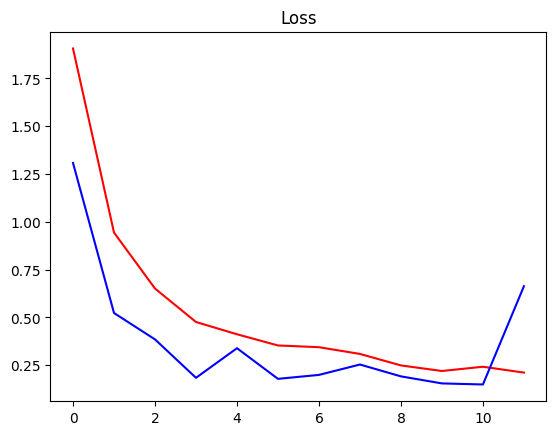

In [33]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

plt.savefig(os.path.join(PLOTS_DIR, f'loss-{NEW_MODEL_NAME}-{MODEL_ARCH}-{MODEL_TYPE}.png'))

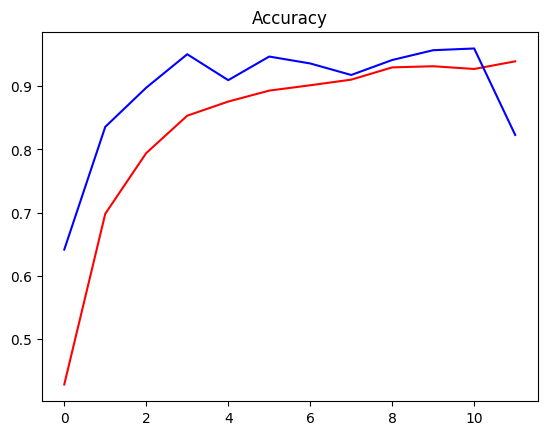

In [34]:
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], 'r')
plt.plot(hist.history['val_accuracy'], 'b')
plt.show()

plt.savefig(os.path.join(PLOTS_DIR, f'accuracy-{NEW_MODEL_NAME}-{MODEL_ARCH}-{MODEL_TYPE}.png'))

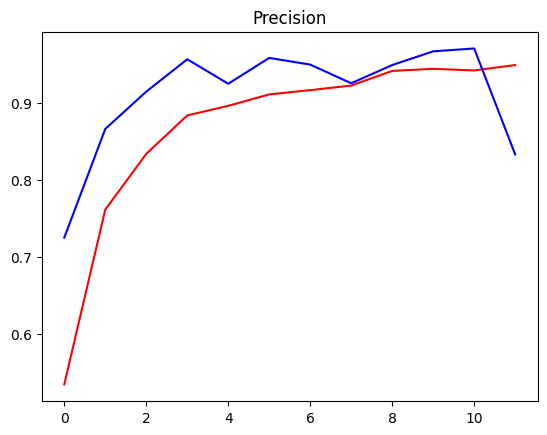

In [35]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

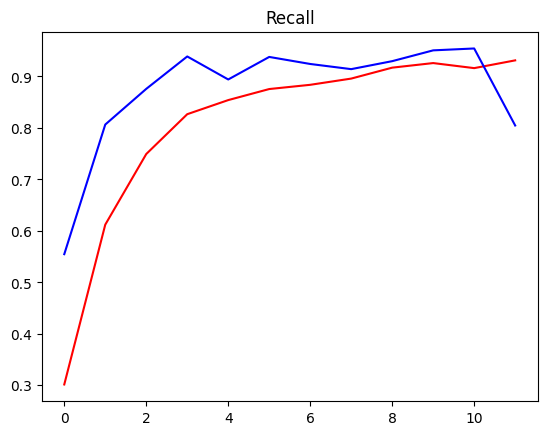

In [36]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

# 5. Make a Prediction on a Single Clip

## 5.1 Make a Prediction, Evaluate

In [37]:
predictions = model.predict(x_test)

35/35 [==============================] - 5s 53ms/step


In [38]:
print(idx2label(predictions[19], oh_encoder))
print(idx2label(y_test[19], oh_encoder))
print(f"input default shape: {x_test[1].shape}")
print(f"reshaped input feature shape: {np.expand_dims((x_test[21]), axis=0).shape}")

metal_metal
metal_metal
input default shape: (38, 256, 1)
reshaped input feature shape: (1, 38, 256, 1)


In [39]:
prediction = model.predict(np.expand_dims((x_test[1]), axis=0))
print(prediction)
print(idx2label(prediction, oh_encoder))

1/1 [==============================] - 0s 314ms/step
[[5.7473214e-04 1.5284393e-06 3.2099517e-05 1.8189187e-04 2.4147513e-07
  7.0396176e-04 6.4250016e-05 9.9843007e-01 1.1071534e-05]]
metal_wood_knock


In [40]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=1)
print("Testing Accuracy: ", score[1])

137/137 [==============================] - 11s 59ms/step - loss: 0.5899 - accuracy: 0.8418 - precision: 0.8539 - recall: 0.8299
Training Accuracy:  0.8417808413505554
35/35 [==============================] - 2s 56ms/step - loss: 0.6635 - accuracy: 0.8230 - precision: 0.8336 - recall: 0.8047
Testing Accuracy:  0.8229926824569702


35/35 [==============================] - 2s 56ms/step - loss: 0.6635 - accuracy: 0.8230 - precision: 0.8336 - recall: 0.8047


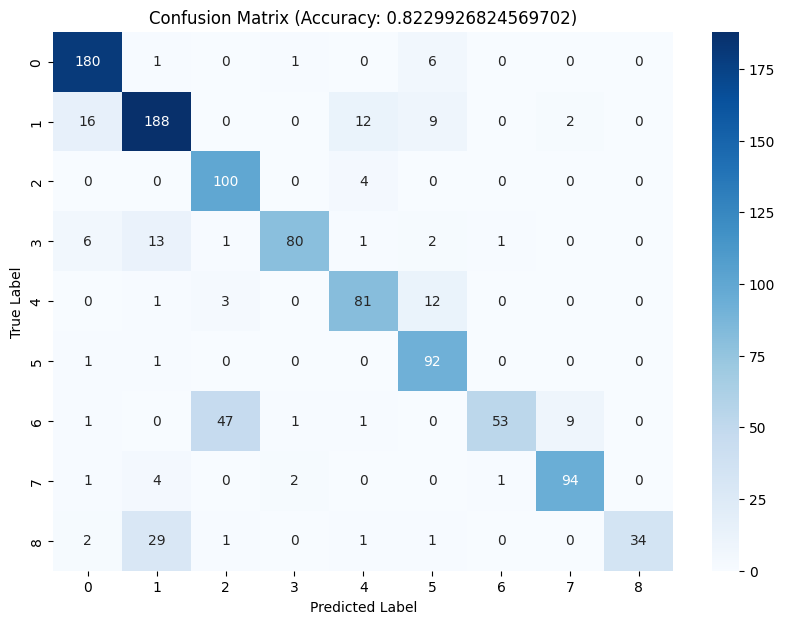

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming 'predictions' is an array of predicted probabilities for each class
# And 'y_test' is an array of actual class labels

# Convert predicted probabilities to class labels
predicted_labels = [idx2label(pred, oh_encoder) for pred in predictions]
y_test_labels = [idx2label(pred, oh_encoder) for pred in y_test]

# Create the confusion matrix
cm = confusion_matrix(y_test_labels, predicted_labels)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
score = model.evaluate(x_test, y_test, verbose=1)

plt.title(f"Confusion Matrix (Accuracy: {score[1]})")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

plt.savefig(os.path.join(PLOTS_DIR, f"confusion_matrix-{NEW_MODEL_NAME}-{MODEL_ARCH}-{MODEL_TYPE}.png"))

## 5.2 Save Model

In [60]:
model.save(f"{MODEL_PATH}.keras")
joblib.dump(oh_encoder, LABELER_PATH)

['MODEL\\labeler-test01-effnetv2_nn-base.joblib']

## 5.3 Save for TF-lite

In [61]:
model.save(MODEL_PATH, save_format='tf')

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_PATH)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Optional: apply optimizations for quantization
tflite_model = converter.convert()
with open(LITE_MODEL_PATH, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: MODEL\model-test01-effnetv2_nn-base\assets


INFO:tensorflow:Assets written to: MODEL\model-test01-effnetv2_nn-base\assets


# 6. Inference 

## 6.1 Load local model and labels

In [46]:
# Load the encoder in the inference environment
loaded_encoder = joblib.load(LABELER_PATH)
model = tf.keras.models.load_model(f"{MODEL_PATH}.keras")

## 6.1 Inference on local files

In [49]:
audio_files = os.listdir(TEST_DIR)
random.shuffle(audio_files)

try:
    print(audio_files[1])
    audio_labels = [os.path.splitext(file)[0] for file in audio_files]
except IndexError:
    print("No files in test directory")

chardonnay_cheers_indoor_filled_0008.wav


In [53]:
import time 

for file in audio_files:
    path = os.path.join(TEST_DIR, file)
    print("Playing file:", file)
    data, _ = librosa.load(path, sr=SAMPLE_RATE)
    
    prediction_feature = audio_processor(data=data, data_range=DATA_RANGE)
    
    # Reshape to match model input shape
    prediction_feature = prediction_feature.reshape(1, N_FRAMES, N_MELS, NUM_CHANNELS)
    predicted_class = idx2label(model.predict(prediction_feature), loaded_encoder) 
    
    # Play the audio
    display(Audio(data, rate=SAMPLE_RATE))
    
    # Display the predicted class
    print("The predicted class is:", predicted_class, '\n')
    
    # Wait for 2 seconds
    time.sleep(2)

Playing file: klatschen_0038.wav
1/1 [==============================] - 0s 77ms/step


The predicted class is: metal_metal_knock 

Playing file: chardonnay_cheers_indoor_filled_0008.wav
1/1 [==============================] - 0s 73ms/step


The predicted class is: cheers 

Playing file: champaign_cheers_full_0023.wav
1/1 [==============================] - 0s 57ms/step


The predicted class is: cheers 

Playing file: bim_0019.wav
1/1 [==============================] - 0s 56ms/step


The predicted class is: cheers 

Playing file: champaign_cheers_full_0019.wav
1/1 [==============================] - 0s 55ms/step


The predicted class is: cheers 

Playing file: listen_ding1550416130.156109.wav
1/1 [==============================] - 0s 56ms/step


The predicted class is: clap 

Playing file: pinotNoir_cheers_indoor_filled2_0013.wav
1/1 [==============================] - 0s 54ms/step


The predicted class is: attention 

Playing file: listen_ding1550418211.3250322.wav
1/1 [==============================] - 0s 67ms/step


The predicted class is: cheers 

Playing file: bim_0022.wav
1/1 [==============================] - 0s 55ms/step


The predicted class is: cheers 

Playing file: bim_0016.wav
1/1 [==============================] - 0s 55ms/step


The predicted class is: cheers 

Playing file: klatschen_0035.wav
1/1 [==============================] - 0s 55ms/step


The predicted class is: finger_snap 

Playing file: klatschen_0032.wav
1/1 [==============================] - 0s 55ms/step


The predicted class is: metal_metal_knock 

Playing file: pinotNoir_cheers_indoor_filled2_0014.wav
1/1 [==============================] - 0s 55ms/step


The predicted class is: cheers 

Playing file: chardonnay_cheers_indoor_filled_0006.wav
1/1 [==============================] - 0s 56ms/step


The predicted class is: attention 



## 6.2 Real-time inference

## run "run.py"

In [ ]:
from inference_class import SoundClassificationService

def main():

    config = {
        "model_path": MODEL_PATH,
        "labels_path": LABELER_PATH,
        
        "sample_rate": SAMPLE_RATE,
        "num_channels": NUM_CHANNELS,
        "audio_chunk": AUDIO_CHUNK,
        
        "num_mels": N_MELS,
        "n_fft": NFFT,
        "fmax": FMAX,
        "hop_length": HOP_LENGTH,
        
        "confidence_threshold": 0.8,
        "listening_hop_length": 0.5,
        "device": "cpu",
        "data_range": DATA_RANGE
        

    }

    service = SoundClassificationService.get_instance(config)
    service.listen_and_predict(duration=AUDIO_CHUNK, overlap=0.5)


if __name__ == "__main__":
    main()

C:\Users\Unreal\AppData\Local\Temp\ipykernel_28240\23151764.py:27: RuntimeWarning: coroutine 'SoundClassificationService.listen_and_predict' was never awaited
  service.listen_and_predict(duration=AUDIO_CHUNK, overlap=0.5)
